In [1]:
import os
import math

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.rrt.rrt import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images, gen_agents,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional

from matplotlib import cm


# Args
config_dir = "./scorefield/configs/rrt.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

delta_dist = args['delta_dist']
radius = args['radius']
time_steps = args['time_steps']
seed = args['seed']


class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
        return score

    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

rrt = RRTStar(
    image_size=img_size,
    time_steps=time_steps,
    delta_dist=delta_dist,
    radius=radius,
    device=device,
)

/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model.load_state_dict(torch.load(f'./runs/baselines/Sep16_14-59-56/model_params.pt'))

<All keys matched successfully>

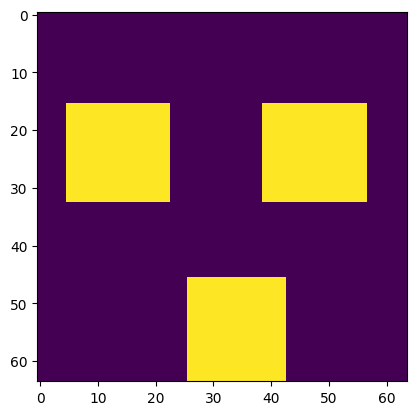

In [3]:
# Evaluation pre-setting

# background = draw_obstacles_pil(bg, obstacle_pos)
# obstacle_masks = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)
obstacle_masks = randgen_obstacle_masks(1, img_size, seed=seed)
background = draw_obstacles_pixel(bg, obstacle_masks)

obstacle_masks = obstacle_masks[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()


19it [00:00, 83.24it/s]


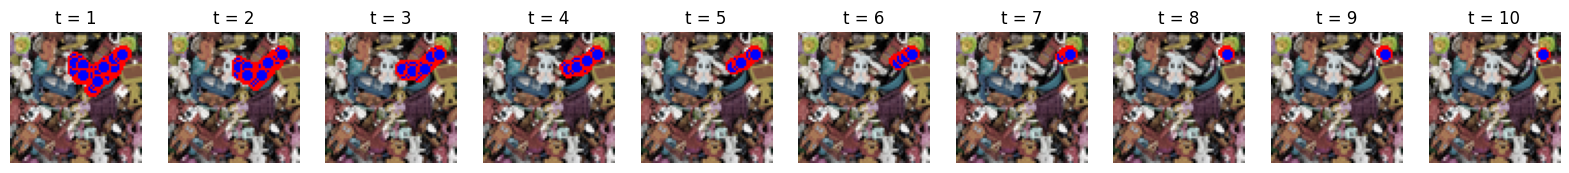

In [48]:
# Evaluation - Single goal

goals = torch.tensor([[[-0.8, 0.8], [-0.8,-0.8]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)

c = 10
fig, axs = plt.subplots(1, c, figsize=(20,20))

step_size = time_steps // c
dot_size = 3


model.eval()
ims = []

with torch.no_grad():
    # x_T = torch.tensor([[[0.8, -0.]]], device=device, dtype=torch.float32)
    x_T = gen_goals(goal_bounds, (1000,1), img_size, obstacles=obstacle_masks, seed=seed)
    x = x_T
    
    for i in tqdm(reversed(range(1, time_steps+10)), position=0):
        if (time_steps-i) % step_size == 0:
            k = (time_steps-i) // step_size
            backg = background.copy()

            img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), dot_size)

            for s in range(len(img_sample)):
                if len(wastes) == 1:
                    axs[k].imshow(img_sample[s])
                    axs[k].set_title(f't = {time_steps-i+1}')
                    axs[k].axis('off')
                else:
                    axs[s,k].imshow(img_sample[s])
                    axs[0,k].set_title(f't = {time_steps-i+1}')
                    axs[s,k].axis('off')

        t = torch.ones(1).long().to(device)

        x_prev = x.clone()
        delta  = model(obs_T, t, x)

        x = x + delta

        bkg = background.copy()
        ims.append(overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size))

    backg = background.copy()
    img_sample = overlay_goal_agent(backg, wastes, goals.cpu(),x.cpu(), dot_size)

    for s in range(len(img_sample)):
        if len(wastes) == 1:
            axs[-1].imshow(img_sample[s])
            axs[-1].set_title(f't = {time_steps}')
            axs[-1].axis('off')    
        else:
            axs[s,-1].imshow(img_sample[s])
            axs[0,-1].set_title(f't = {time_steps}')
            axs[s,-1].axis('off')

    bkg = background.copy()
    ims.append(overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size))

In [50]:
np.save('./results/rrt/eval.npy', ims)